Mounted at /content/drive


100%|██████████| 170M/170M [00:14<00:00, 11.6MB/s]


Extracting /content/drive/MyDrive/CIFAR_data/cifar-10-python.tar.gz to /content/drive/MyDrive/CIFAR_data
Files already downloaded and verified


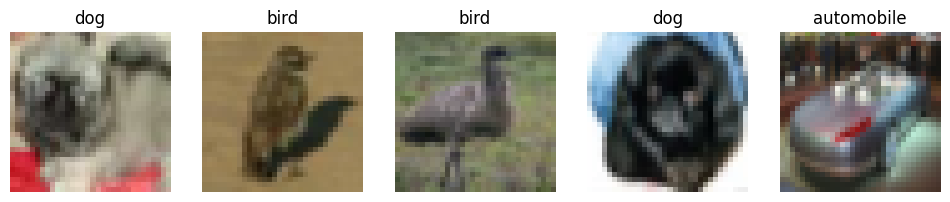

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 67.0MB/s

Accuracy of ResNet-20 on CIFAR-10 test images: 92.12%


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import os

#############################
#   1. MOUNT GOOGLE DRIVE   #
#############################
# If you're running on Google Colab, mount Drive:
from google.colab import drive
drive.mount('/content/drive')

# Define a custom data directory in Drive:
GDRIVE_DATA_PATH = '/content/drive/MyDrive/CIFAR_data'
os.makedirs(GDRIVE_DATA_PATH, exist_ok=True)

# ------------------------------
# 2. Define Transform & Classes
# ------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # Standard CIFAR-10 normalization
])

cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# ------------------------------
# 3. Download (If Needed) and Load CIFAR-10
# ------------------------------
# IMPORTANT ASSUMPTION (Repeated):
# - We store/download CIFAR-10 to Google Drive at `GDRIVE_DATA_PATH`.
# - If it's already there, torchvision will detect the 'CIFAR10' directory
#   and won't need to re-download.

train_full = torchvision.datasets.CIFAR10(
    root=GDRIVE_DATA_PATH,
    train=True,
    download=True,   # Will only download if not found
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root=GDRIVE_DATA_PATH,
    train=False,
    download=True,   # Will only download if not found
    transform=transform
)

# For a validation split, if desired:
train_size = 45000
val_size = 5000
train_dataset, val_dataset = torch.utils.data.random_split(train_full, [train_size, val_size])

batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ------------------------------
# 4. Display 5 Random Samples
# ------------------------------
def show_random_samples(dataset, classes, num_samples=5):
    """
    Displays 'num_samples' random images from the provided dataset.
    """
    import matplotlib.pyplot as plt
    indices = random.sample(range(len(dataset)), num_samples)
    fig, axs = plt.subplots(1, num_samples, figsize=(12, 3))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        # Convert from (C, H, W) to (H, W, C)
        img_np = img.permute(1, 2, 0).numpy()
        # Undo normalization for display
        img_np = img_np * (0.2470, 0.2435, 0.2616) + (0.4914, 0.4822, 0.4465)
        img_np = img_np.clip(0, 1)

        axs[i].imshow(img_np)
        axs[i].set_title(classes[label])
        axs[i].axis('off')
    plt.show()

show_random_samples(train_dataset, cifar10_classes, num_samples=5)

# ------------------------------
# 5. Load Pre-trained ResNet-20 & Evaluate
# ------------------------------
target_model = torch.hub.load(
    "chenyaofo/pytorch-cifar-models",
    "cifar10_resnet20",
    pretrained=True
)
target_model.eval()

correct = 0
total = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target_model.to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = target_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100.0 * correct / total
print(f"Accuracy of ResNet-20 on CIFAR-10 test images: {accuracy:.2f}%")


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import json

#############################################
#              Generator Model
#############################################
class Pix2PixGenerator(nn.Module):
    """
    A simplified U-Net for 32×32 images, with fewer channels than typical
    large Pix2Pix. You can expand if you want bigger capacity.
    """
    def __init__(self, in_channels=3, out_channels=3):
        super(Pix2PixGenerator, self).__init__()

        # -- Encoder --
        # conv1: in_channels -> 64
        self.down1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # conv2: 64 -> 128
        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # conv3: 128 -> 256
        self.down3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Bottleneck at 4×4 (for 32×32 input)
        self.down4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # -- Decoder --
        # up4: 512 -> 256
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        # up3: 256 + 256 -> 128
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        # up2: 128 + 128 -> 64
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        # up1: 64 + 64 -> out_channels
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)   # shape: [64, 16, 16]
        d2 = self.down2(d1)  # shape: [128, 8, 8]
        d3 = self.down3(d2)  # shape: [256, 4, 4]
        d4 = self.down4(d3)  # shape: [512, 2, 2]

        # Decoder
        u4 = self.up4(d4)    # shape: [256, 4, 4]
        # skip with d3
        u3 = self.up3(torch.cat([u4, d3], dim=1))  # shape: [128, 8, 8]
        # skip with d2
        u2 = self.up2(torch.cat([u3, d2], dim=1))  # shape: [64, 16, 16]
        # skip with d1
        u1 = self.up1(torch.cat([u2, d1], dim=1))  # shape: [3, 32, 32] => Tanh in [-1,1]

        return u1

#############################################
#             Discriminator Model
#############################################
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(PatchGANDiscriminator, self).__init__()
        # We'll produce an output of shape [N,1,4,4] or [N,1,2,2] for 32×32 input
        # (the exact size depends on how many conv layers we add).

        model = []
        # 1) 3 -> 64
        model += [
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        # 2) 64 -> 128
        model += [
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        # 3) 128 -> 256
        model += [
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        # 4) 256 -> 512
        model += [
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        # final 512 -> 1
        model += [
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
            # no activation => raw output
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)  # shape ~ [N, 1, 2, 2] or [N,1,3,3], etc.

#############################################
#               CW Loss
#############################################
def cw_loss(logits, target, confidence=0):
    """
    logits: [batch_size, num_classes]
      -> In typical usage, these would be classifier logits.
         For a standard Discriminator, we might only have shape [batch_size, 1].
         So ensure your shape matches the usage.
    target: [batch_size], each entry in [0..num_classes-1]
    confidence: the 'kappa' or margin in CW. Default=0.
    """
    num_classes = logits.size(1)  # Must be > 1 for multi-class
    # Check target validity
    assert target.max() < num_classes, "Target contains invalid class indices."

    # Correct logit
    correct_logit = logits[torch.arange(logits.size(0)), target]

    # Max of other logits
    mask = torch.eye(num_classes, device=logits.device)[target]  # shape [batch_size, num_classes]
    # Replace the correct index with -inf, so we find max among "others"
    max_other_logit = torch.max(logits.masked_fill(mask.bool(), float('-inf')), dim=1)[0]

    # CW objective: max( max_other - correct + confidence, 0 )
    return torch.mean(torch.clamp(max_other_logit - correct_logit + confidence, min=0))

#############################################
#              LSGAN Loss
#############################################
def lsgan_loss(predictions, is_real=True):
    # predictions: [N,1,H_out,W_out]
    # Flatten the patch dimension so MSELoss can compare with a tensor of same shape
    target_val = 1.0 if is_real else 0.0
    target = torch.full_like(predictions, target_val)  # same shape
    return nn.MSELoss()(predictions, target)

#############################################
#              Hinge Loss
#############################################
def hinge_loss(perturbations, c=1):
    """
    Force L2 norm of perturbations to be <= c,
    i.e. hinge penalty if the norm exceeds 'c'.
    """
    # Flatten each image to shape [batch_size, -1], compute norm, then clamp.
    norms = torch.norm(perturbations.view(perturbations.size(0), -1), dim=1)
    return torch.mean(torch.relu(norms - c))

#############################################
#           Initialize & Hyperparams
#############################################
# Define hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
alpha = 1.0  # weight for LSGAN
beta = 0.1   # weight for hinge
c = 1.0      # hinge threshold
epochs = 50

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Define data paths (ensure GDRIVE_DATA_PATH is defined)
GDRIVE_DATA_PATH = './data'  # Update this path as needed

# Load datasets
train_full = torchvision.datasets.CIFAR10(
    root=GDRIVE_DATA_PATH,
    train=True,
    download=True,   # Will only download if not found
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root=GDRIVE_DATA_PATH,
    train=False,
    download=True,   # Will only download if not found
    transform=transform
)

# Split into training and validation
train_size = 45000
val_size = 5000
train_dataset, val_dataset = torch.utils.data.random_split(train_full, [train_size, val_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize models
generator = Pix2PixGenerator(in_channels=3, out_channels=3).to(device)
discriminator = PatchGANDiscriminator(in_channels=3).to(device)

# Initialize optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))

# Initialize tracking lists
losses = {'d_loss': [], 'g_loss': []}
attack_success_history = []       # Track attack success rate
target_model_acc_history = []     # Track target model accuracy
discriminator_acc_history = []    # Track discriminator accuracy

#############################################
#         Helper Functions
#############################################
def get_target_labels(labels, num_classes=10):
    """
    Maps each label to the next class in a cyclic manner.

    Args:
        labels (Tensor): Tensor of shape [batch_size] containing true labels.
        num_classes (int): Total number of classes.

    Returns:
        Tensor: Tensor of shape [batch_size] containing target labels.
    """
    return (labels + 1) % num_classes

def compute_discriminator_accuracy(discriminator, real_batch, fake_batch):
    """
    Compute the discriminator's accuracy in classifying real and fake images.
    """
    discriminator.eval()
    with torch.no_grad():
        # Real images
        out_real = discriminator(real_batch)
        avg_real = out_real.mean(dim=[1,2,3])
        correct_real = (avg_real > 0.5).sum().item()

        # Fake images
        out_fake = discriminator(fake_batch)
        avg_fake = out_fake.mean(dim=[1,2,3])
        correct_fake = (avg_fake < 0.5).sum().item()

        # Total accuracy
        total = real_batch.size(0) + fake_batch.size(0)
        disc_acc = 100.0 * (correct_real + correct_fake) / total

    discriminator.train()
    return disc_acc

#############################################
#         Load Pre-trained Target Model
#############################################
# Ensure you have internet access; otherwise, download the model manually
target_model = torch.hub.load(
    "chenyaofo/pytorch-cifar-models",
    "cifar10_resnet20",
    pretrained=True
)
target_model.eval()
target_model.to(device)

#############################################
#              Training Loop
#############################################
for epoch in range(epochs):
    epoch_d_loss, epoch_g_loss = 0.0, 0.0
    disc_acc_sum = 0.0
    disc_acc_count = 0

    for real_images, labels in train_loader:
        real_images = real_images.to(device)
        labels = labels.to(device)

        # Define target labels for targeted attack
        target_labels = get_target_labels(labels, num_classes=10).to(device)

        ########################################
        # (1) Train Discriminator
        ########################################
        optimizer_D.zero_grad()

        real_logits = discriminator(real_images)
        d_loss_real = lsgan_loss(real_logits, is_real=True)

        fake_images_detached = generator(real_images).detach()
        fake_logits = discriminator(fake_images_detached)
        d_loss_fake = lsgan_loss(fake_logits, is_real=False)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        ########################################
        # (2) Train Generator
        ########################################
        optimizer_G.zero_grad()

        adv_images = generator(real_images)
        adv_images_for_target = (adv_images + 1) / 2
        adv_images_for_target = torch.clamp(adv_images_for_target, 0, 1)

        # Get target model logits for adversarial examples
        logits_target = target_model(adv_images_for_target)

        # Compute CW loss with target labels
        adv_loss = cw_loss(logits_target, target_labels, confidence=0)

        # Compute adversarial loss to fool the discriminator
        fake_logits_forG = discriminator(adv_images)
        g_loss_lsgan = lsgan_loss(fake_logits_forG, is_real=True)

        # Compute hinge penalty on perturbations
        perturb = adv_images - real_images
        hinge_penalty = hinge_loss(perturb, c=c)

        # Total generator loss
        g_loss = adv_loss + alpha * g_loss_lsgan + beta * hinge_penalty
        g_loss.backward()
        optimizer_G.step()

        # Track losses
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()

        # Compute discriminator accuracy for this batch
        disc_batch_acc = compute_discriminator_accuracy(
            discriminator, real_images, fake_images_detached
        )
        disc_acc_sum += disc_batch_acc
        disc_acc_count += 1

    # Average losses and discriminator accuracy for the epoch
    epoch_d_loss /= len(train_loader)
    epoch_g_loss /= len(train_loader)
    disc_acc = disc_acc_sum / disc_acc_count

    # Record losses and discriminator accuracy
    losses['d_loss'].append(epoch_d_loss)
    losses['g_loss'].append(epoch_g_loss)
    discriminator_acc_history.append(disc_acc)

    # Evaluate target model accuracy on adversarial examples
    generator.eval()
    correct_target = 0
    total_target = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            bs_val = val_images.size(0)
            total_target += bs_val

            # Generate adversarial examples
            adv_val = generator(val_images)
            adv_val_for_target = (adv_val + 1) / 2
            adv_val_for_target = torch.clamp(adv_val_for_target, 0, 1)

            # Get target model predictions
            logits_val = target_model(adv_val_for_target)
            preds_val = torch.argmax(logits_val, dim=1)

            # Define target labels for evaluation
            target_labels_val = get_target_labels(val_labels, num_classes=10).to(device)

            # Compute correct predictions towards target labels
            correct_target += (preds_val == target_labels_val).sum().item()

    # Calculate accuracy and attack success rate
    target_acc = 100.0 * correct_target / total_target
    attack_success = 100.0 - target_acc

    # Record metrics
    target_model_acc_history.append(target_acc)
    attack_success_history.append(attack_success)

    # Resume training mode
    generator.train()

    # Print epoch summary
    print(f"[Epoch {epoch+1}/{epochs}] "
          f"D Loss: {epoch_d_loss:.4f}, G Loss: {epoch_g_loss:.4f}, "
          f"D Acc: {disc_acc:.2f}%, "
          f"Target Model Acc: {target_acc:.2f}%, "
          f"Attack Success Rate: {attack_success:.2f}%")

#############################################
#               Save Metrics
#############################################
# Save the metrics for later plotting
metrics = {
    'discriminator_accuracy': discriminator_acc_history,
    'target_model_accuracy': target_model_acc_history,
    'attack_success_rate': attack_success_history,
    'd_loss': losses['d_loss'],
    'g_loss': losses['g_loss']
}

with open('training_metrics.json', 'w') as f:
    json.dump(metrics, f)


100%|██████████| 170M/170M [00:14<00:00, 12.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


[Epoch 1/50] D Loss: 0.4232, G Loss: 4.0284, D Acc: 58.75%, Target Model Acc: 8.48%, Attack Success Rate: 91.52%
[Epoch 2/50] D Loss: 0.2144, G Loss: 3.1868, D Acc: 54.31%, Target Model Acc: 9.66%, Attack Success Rate: 90.34%
[Epoch 3/50] D Loss: 0.2461, G Loss: 2.7965, D Acc: 59.33%, Target Model Acc: 10.36%, Attack Success Rate: 89.64%
[Epoch 4/50] D Loss: 0.1914, G Loss: 2.8217, D Acc: 53.09%, Target Model Acc: 12.06%, Attack Success Rate: 87.94%
[Epoch 5/50] D Loss: 0.1792, G Loss: 2.6265, D Acc: 51.83%, Target Model Acc: 11.48%, Attack Success Rate: 88.52%
[Epoch 6/50] D Loss: 0.2060, G Loss: 2.5579, D Acc: 51.67%, Target Model Acc: 14.74%, Attack Success Rate: 85.26%
[Epoch 7/50] D Loss: 0.1707, G Loss: 2.4544, D Acc: 50.18%, Target Model Acc: 17.46%, Attack Success Rate: 82.54%
[Epoch 8/50] D Loss: 0.1686, G Loss: 2.3858, D Acc: 51.39%, Target Model Acc: 16.82%, Attack Success Rate: 83.18%
[Epoch 9/50] D Loss: 0.2012, G Loss: 2.2974, D Acc: 52.56%, Target Model Acc: 20.02%, Atta

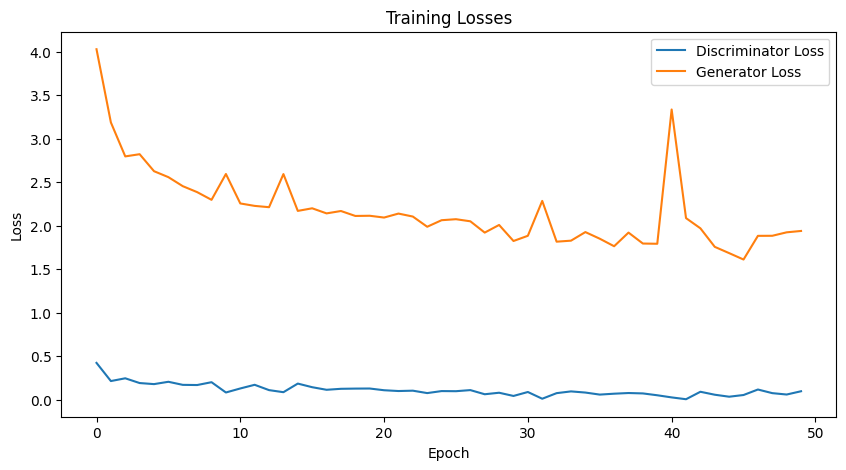

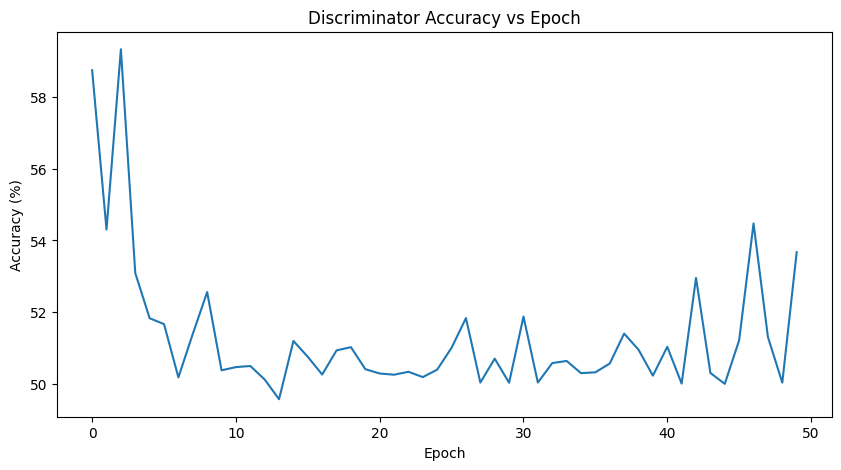

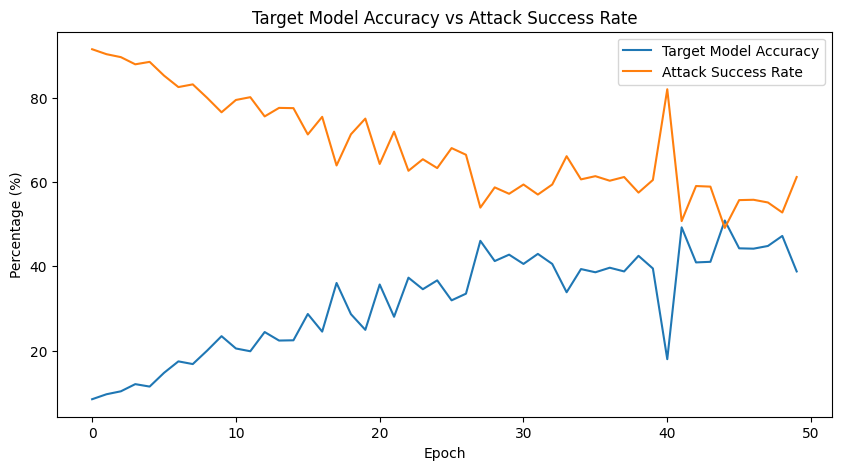

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
#############################################
#           Plot the Loss Curves
#############################################
plt.figure(figsize=(10, 5))
plt.plot(losses['d_loss'], label='Discriminator Loss')
plt.plot(losses['g_loss'], label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


with open('training_metrics.json', 'r') as f:
    metrics = json.load(f)

# Plot discriminator accuracy
plt.figure(figsize=(10, 5))
plt.plot(metrics['discriminator_accuracy'])
plt.title('Discriminator Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

# Plot target model accuracy and attack success rate
plt.figure(figsize=(10, 5))
plt.plot(metrics['target_model_accuracy'], label='Target Model Accuracy')
plt.plot(metrics['attack_success_rate'], label='Attack Success Rate')
plt.title('Target Model Accuracy vs Attack Success Rate')
plt.xlabel('Epoch')
plt.ylabel('Percentage (%)')
plt.legend()
plt.show()


In [4]:
import torch.nn.functional as F

# Move generator to eval mode just for good measure
generator.eval()

all_normal_confidences = []
all_adv_confidences = []

success_count = 0
total_count = 0

num_classes = 10
class_totals = [0]*num_classes
class_successes = [0]*num_classes

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        batch_size = images.size(0)
        total_count += batch_size

        ########################################
        # 1) Run target model on NORMAL images
        ########################################
        # If your images are in [0,1] but the target model expects something else (e.g., normalized),
        # apply that transform here. For demonstration, we assume it's fine as-is:
        logits_normal = target_model(images)
        preds_normal = torch.argmax(logits_normal, dim=1)

        # Confidence = max softmax probability
        probs_normal = F.softmax(logits_normal, dim=1)
        normal_confidence = probs_normal[torch.arange(batch_size), preds_normal]
        all_normal_confidences.append(normal_confidence.cpu())

        ########################################
        # 2) Generate adversarial images with G
        ########################################
        # The generator expects input in [-1,1]? If your real_images are [0,1],
        # you might need to map them to [-1,1]:  X' = (X * 2) - 1
        # Conversely, the generator output is in [-1,1] and the target model expects [0,1],
        # so we map G_out from [-1,1] to [0,1].
        # Example:
        real_images_4G = images * 2 - 1  # Now in [-1,1]
        adv_out = generator(real_images_4G)  # shape [N,3,32,32], in [-1,1]
        # Map back to [0,1] for the target model
        adv_images = (adv_out + 1)/2
        adv_images = torch.clamp(adv_images, 0, 1)

        ########################################
        # 3) Run target model on ADV images
        ########################################
        logits_adv = target_model(adv_images)
        preds_adv = torch.argmax(logits_adv, dim=1)

        # Confidence in adv predictions
        probs_adv = F.softmax(logits_adv, dim=1)
        adv_confidence = probs_adv[torch.arange(batch_size), preds_adv]
        all_adv_confidences.append(adv_confidence.cpu())

        ########################################
        # 4) Evaluate success
        ########################################
        # Attack is "successful" if adv_pred != true_label
        #   (some definitions also require that original pred == true_label,
        #    but the simplest is to see if adv_pred is different from ground truth.)
        different = (preds_adv != labels).sum().item()
        success_count += different

        # Also track per-class
        for i in range(batch_size):
            class_idx = labels[i].item()
            class_totals[class_idx] += 1
            if preds_adv[i] != labels[i]:
                class_successes[class_idx] += 1

# Overall
overall_success_rate = 100.0 * success_count / total_count
print(f"Overall Attack Success Rate: {overall_success_rate:.2f}%")

for c in range(num_classes):
    if class_totals[c] > 0:
        class_sr = 100.0 * class_successes[c] / class_totals[c]
        print(f"Class {c} ({cifar10_classes[c]}): success rate = {class_sr:.2f}%  "
              f"({class_successes[c]}/{class_totals[c]})")


Overall Attack Success Rate: 85.45%
Class 0 (airplane): success rate = 75.60%  (756/1000)
Class 1 (automobile): success rate = 100.00%  (1000/1000)
Class 2 (bird): success rate = 98.70%  (987/1000)
Class 3 (cat): success rate = 70.50%  (705/1000)
Class 4 (deer): success rate = 92.20%  (922/1000)
Class 5 (dog): success rate = 39.10%  (391/1000)
Class 6 (frog): success rate = 96.70%  (967/1000)
Class 7 (horse): success rate = 99.60%  (996/1000)
Class 8 (ship): success rate = 82.10%  (821/1000)
Class 9 (truck): success rate = 100.00%  (1000/1000)


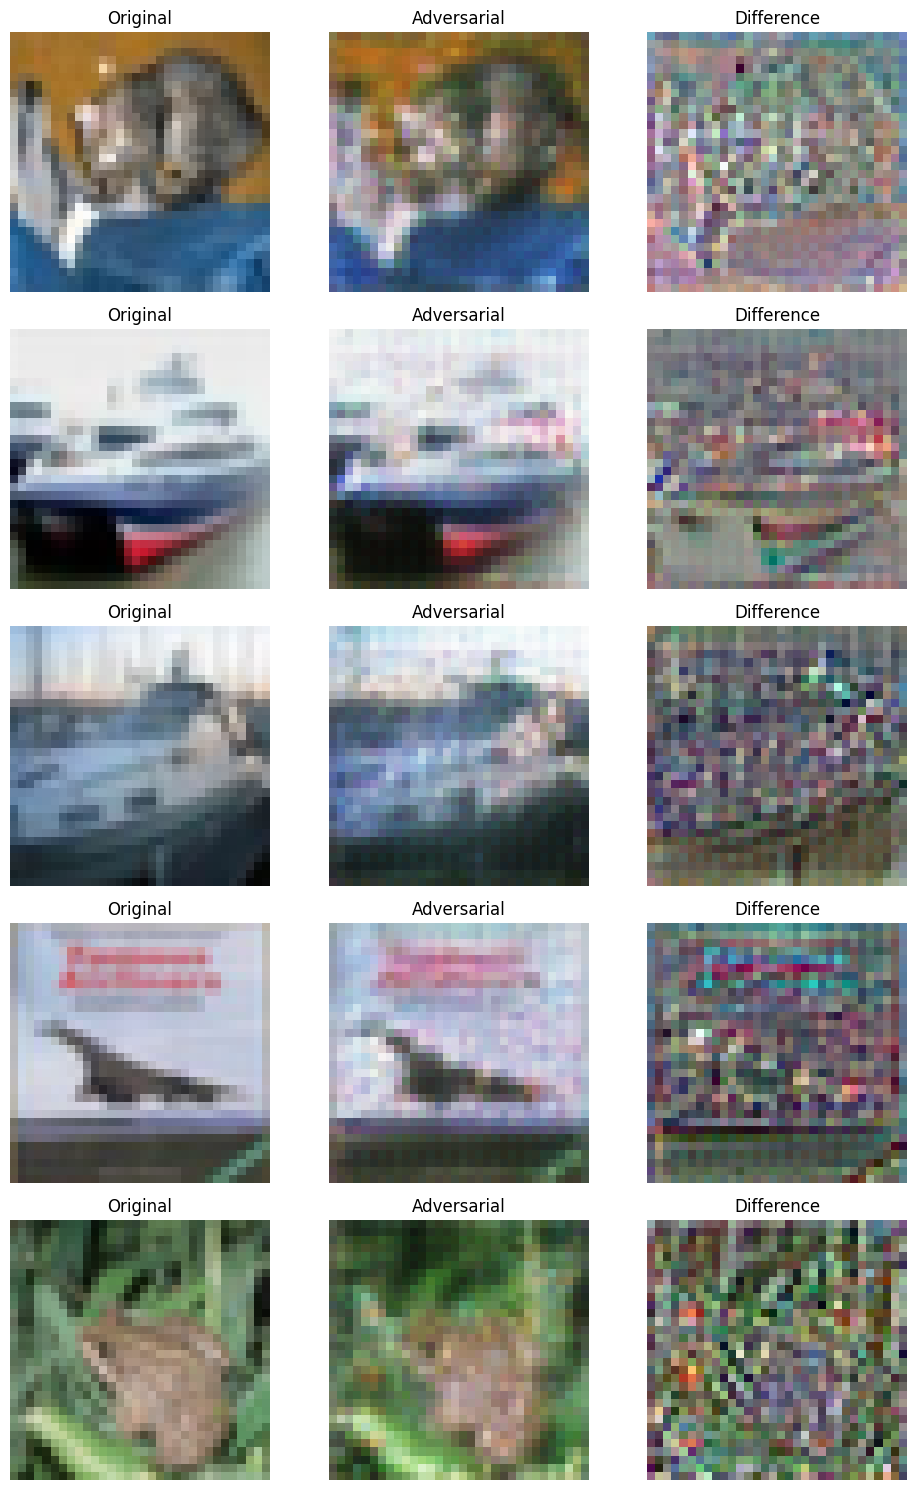

In [5]:
def show_adv_examples(generator, target_model, loader, num_samples=5):
    import random
    import matplotlib.pyplot as plt
    from math import ceil

    generator.eval()
    target_model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    examples = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            # Map [0,1] -> [-1,1] if generator trained that way
            real_images_4G = images * 2 - 1
            adv_out = generator(real_images_4G)  # in [-1,1]
            adv_images = (adv_out + 1)/2
            adv_images = torch.clamp(adv_images, 0, 1)

            for i in range(images.size(0)):
                if len(examples) < num_samples:
                    # store CPU versions for plotting
                    examples.append((
                        images[i].cpu(),
                        adv_images[i].cpu(),
                        labels[i].cpu().item()
                    ))
                else:
                    break
            if len(examples) >= num_samples:
                break

    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 3*num_samples))
    if num_samples == 1:
        axes = [axes]  # make consistent indexing

    for i, (orig_img, adv_img, lbl) in enumerate(examples):
        # Convert from (C,H,W) -> (H,W,C)
        orig_np = orig_img.permute(1,2,0).numpy().clip(0,1)
        adv_np  = adv_img.permute(1,2,0).numpy().clip(0,1)

        diff = adv_np - orig_np
        diff_min, diff_max = diff.min(), diff.max()
        if diff_max - diff_min > 1e-9:
            diff_norm = (diff - diff_min)/(diff_max-diff_min)
        else:
            diff_norm = diff

        axes[i][0].imshow(orig_np)
        axes[i][0].set_title("Original")
        axes[i][0].axis("off")

        axes[i][1].imshow(adv_np)
        axes[i][1].set_title("Adversarial")
        axes[i][1].axis("off")

        axes[i][2].imshow(diff_norm)
        axes[i][2].set_title("Difference")
        axes[i][2].axis("off")

    plt.tight_layout()
    plt.show()

# Show 5 examples
show_adv_examples(generator, target_model, test_loader, num_samples=5)


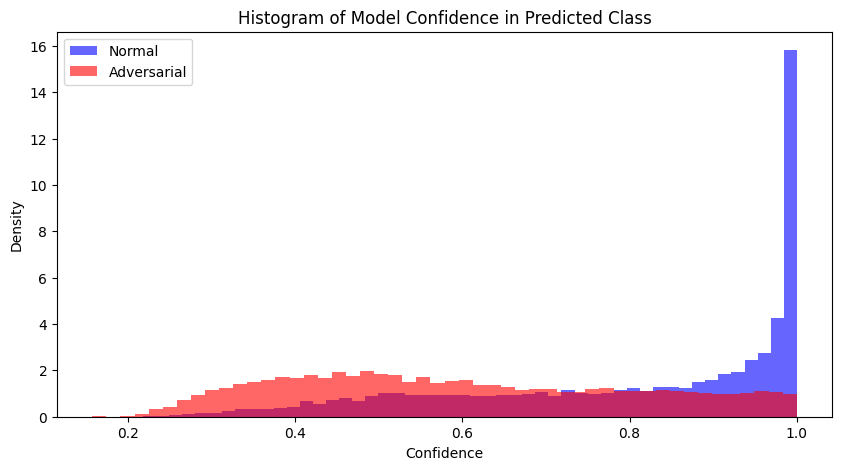

In [6]:
import numpy as np

normal_conf = torch.cat(all_normal_confidences).numpy()
adv_conf    = torch.cat(all_adv_confidences).numpy()

plt.figure(figsize=(10,5))
plt.hist(normal_conf, bins=50, alpha=0.6, label='Normal', color='blue', density=True)
plt.hist(adv_conf, bins=50, alpha=0.6, label='Adversarial', color='red', density=True)
plt.title("Histogram of Model Confidence in Predicted Class")
plt.xlabel("Confidence")
plt.ylabel("Density")
plt.legend()
plt.show()
